# Stock market predictions - Decision Trees and Random Forests

Welcome to my rather scuffed and, frankly, kinda shit implementation of the Decision Tree and Random Forest algorithms for stock market predictions.

The data used in this notebook is sourced from [this Kaggle dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs). Data from the GE stock ticker is used in specific, which can be found in the file "ge.us.txt" in CSV format. The dataset includes OHLC prices and the volume, all in 1-day intervals.

## Goals

The project's goal is to use the models above to predict the closing prices of a certain stock ticker. Namely, we want to predict the closing prices of the stocks over the next m days.

# Data preprocessing

## Importing modules

In [24]:
from joblib import parallel_backend
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.utils import parallel_backend
from xgboost import XGBRegressor
import seaborn as sns
import sklearn


# Utils

In [25]:
def evaluate(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test R2: {r2:.2f}")
    print(f"Test MAPE: {mape:.2f}")

In [26]:
def plot_prediction(y_pred, X_test):
    results = X_test.copy()
    results['Actual'] = y_test
    results['Predicted'] = y_pred
    results = results[['Actual', 'Predicted']]
    print(results.tail())

    plt.figure(figsize=(12, 6))
    plt.plot(results.index, results['Actual'], label='Actual', color='blue')
    plt.plot(results.index, results['Predicted'], label='Predicted', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Stock Closing Price')
    plt.title('Actual vs Predicted Closing Prices')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [27]:
def compare_train_test(model, X_train, X_test, y_train, y_test, model_name):
    y_train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)


    y_test_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    print(f"{model_name} Performance:")
    print(f"Training RMSE: {train_rmse:.2f}, R2: {train_r2:.2f}, MAPE: {train_mape:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}, MAPE: {test_mape:.2f}")
    print()


## Pulling data

In [28]:
df = pd.read_csv("https://github.com/noeruchangd/MLProject/blob/master/data/ge.us.txt?raw=true")

df.drop(['OpenInt','Volume'], axis=1, inplace=True)
df=df.tail(7500)

print(df)

             Date     Open     High      Low    Close
6558   1988-02-05   2.8902   2.9224   2.8176   2.8341
6559   1988-02-08   2.8098   2.8500   2.7936   2.8176
6560   1988-02-09   2.8098   2.8422   2.7693   2.8422
6561   1988-02-10   2.8341   2.8822   2.7859   2.8822
6562   1988-02-11   2.8579   2.9549   2.8422   2.8744
...           ...      ...      ...      ...      ...
14053  2017-11-06  20.5200  20.5300  20.0800  20.1300
14054  2017-11-07  20.1700  20.2500  20.1200  20.2100
14055  2017-11-08  20.2100  20.3200  20.0700  20.1200
14056  2017-11-09  20.0400  20.0710  19.8500  19.9900
14057  2017-11-10  19.9800  20.6800  19.9000  20.4900

[7500 rows x 5 columns]


# Preprocessing steps

In [29]:
df.describe()
df.set_index('Date', inplace=True)

print(df.dtypes)
# plt.figure(figsize = (10 , 5))
# sns.lineplot(df , x = df.index , y = 'Close')


Open     float64
High     float64
Low      float64
Close    float64
dtype: object


Preliminary plotting

Text(0.5, 0, 'Date')

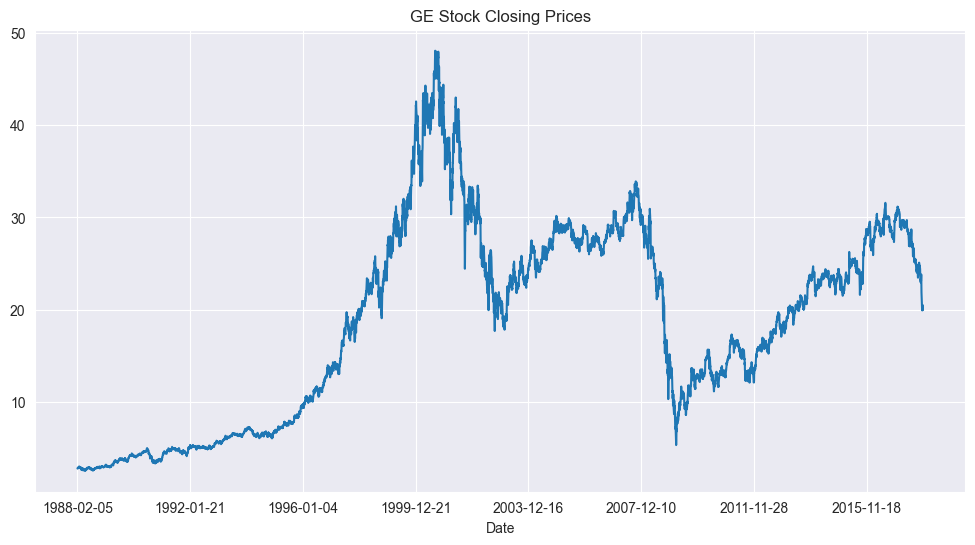

In [30]:
df['Close'].plot(title='GE Stock Closing Prices', figsize=(12, 6))
plt.xlabel('Date')



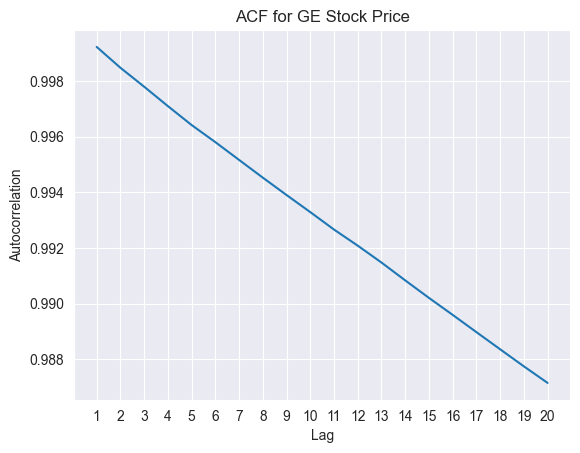

In [31]:
import statsmodels.api as sm # Shoutout to Chau for this!

# ACF for multiple lags
acf = sm.tsa.acf(df['Close'], nlags=20)

# Plot the ACF
plt.plot(range(1, 21), acf[1:])  # Start from lag=1
plt.title('ACF for GE Stock Price')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()

Feature engineering

In [32]:
# Basics
df['Average_price'] = (df['Close'] + df['Open']) / 2


# Moving averages
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
# EMAs
df['EMA_5'] = df['Close'].rolling(window=5).mean()
df['EMA_10'] = df['Close'].rolling(window=10).mean()
df['EMA_20'] = df['Close'].rolling(window=20).mean()

df['STD_5'] = df['Close'].rolling(window=5).std()
df['STD_10'] = df['Close'].rolling(window=10).std()
df['STD_20'] = df['Close'].rolling(window=20).std()
# Lags
df['Close_t-1'] = df['Close'].shift(1)
df['Close_t-2'] = df['Close'].shift(2)
df['Close_t-3'] = df['Close'].shift(3)
#
df.describe()

Open         High          Low        Close  Average_price  \
count  7500.000000  7500.000000  7500.000000  7500.000000    7500.000000   
mean     18.747767    18.940454    18.544260    18.746651      18.747209   
std      10.651652    10.771197    10.530538    10.654252      10.651695   
min       2.600500     2.616600     2.560200     2.584200       2.596350   
25%       7.668550     7.734900     7.606250     7.668550       7.664637   
50%      20.100000    20.312000    19.873500    20.102000      20.098500   
75%      27.350000    27.567000    27.132000    27.351000      27.355000   
max      47.751000    48.459000    47.596000    48.056000      47.856000   

              MA_5        MA_10        MA_20        EMA_5       EMA_10  \
count  7496.000000  7491.000000  7481.000000  7496.000000  7491.000000   
mean     18.750499    18.755341    18.764458    18.750499    18.755341   
std      10.648772    10.643475    10.633699    10.648772    10.643475   
min       2.619840     2.638400     2.658925     2.619840     2.638400   
25%       7.665445     7.662520     7.669780     7.665445     7.662520   
50%      20.097300    20.187800    20.230550    20.097300    20.187800   
75%      27.360650    27.373150    27.419250    27.360650    27.373150   
max      47.521400    47.240200    46.887450    47.521400    47.240200   

            EMA_20        STD_5       STD_10       STD_20    Close_t-1  \
count  7481.000000  7496.000000  7491.000000  7481.000000  7499.000000   
mean     18.764458     0.255339     0.348161     0.479082    18.746419   
std      10.633699     0.266905     0.339687     0.438698    10.654944   
min       2.658925     0.000000     0.014906     0.027617     2.584200   
25%       7.669780     0.076850     0.112962     0.160111     7.664500   
50%      20.230550     0.173827     0.249847     0.354751    20.102000   
75%      27.419250     0.329743     0.461802     0.637881    27.352000   
max      46.887450     2.703550     3.492558     3.526096    48.056000   

         Close_t-2    Close_t-3  
count  7498.000000  7497.000000  
mean     18.746253    18.746070  
std      10.655644    10.656343  
min       2.584200     2.584200  
25%       7.660450     7.656400  
50%      20.102000    20.102000  
75%      27.353000    27.354000  
max      48.056000    48.056000

<Axes: >

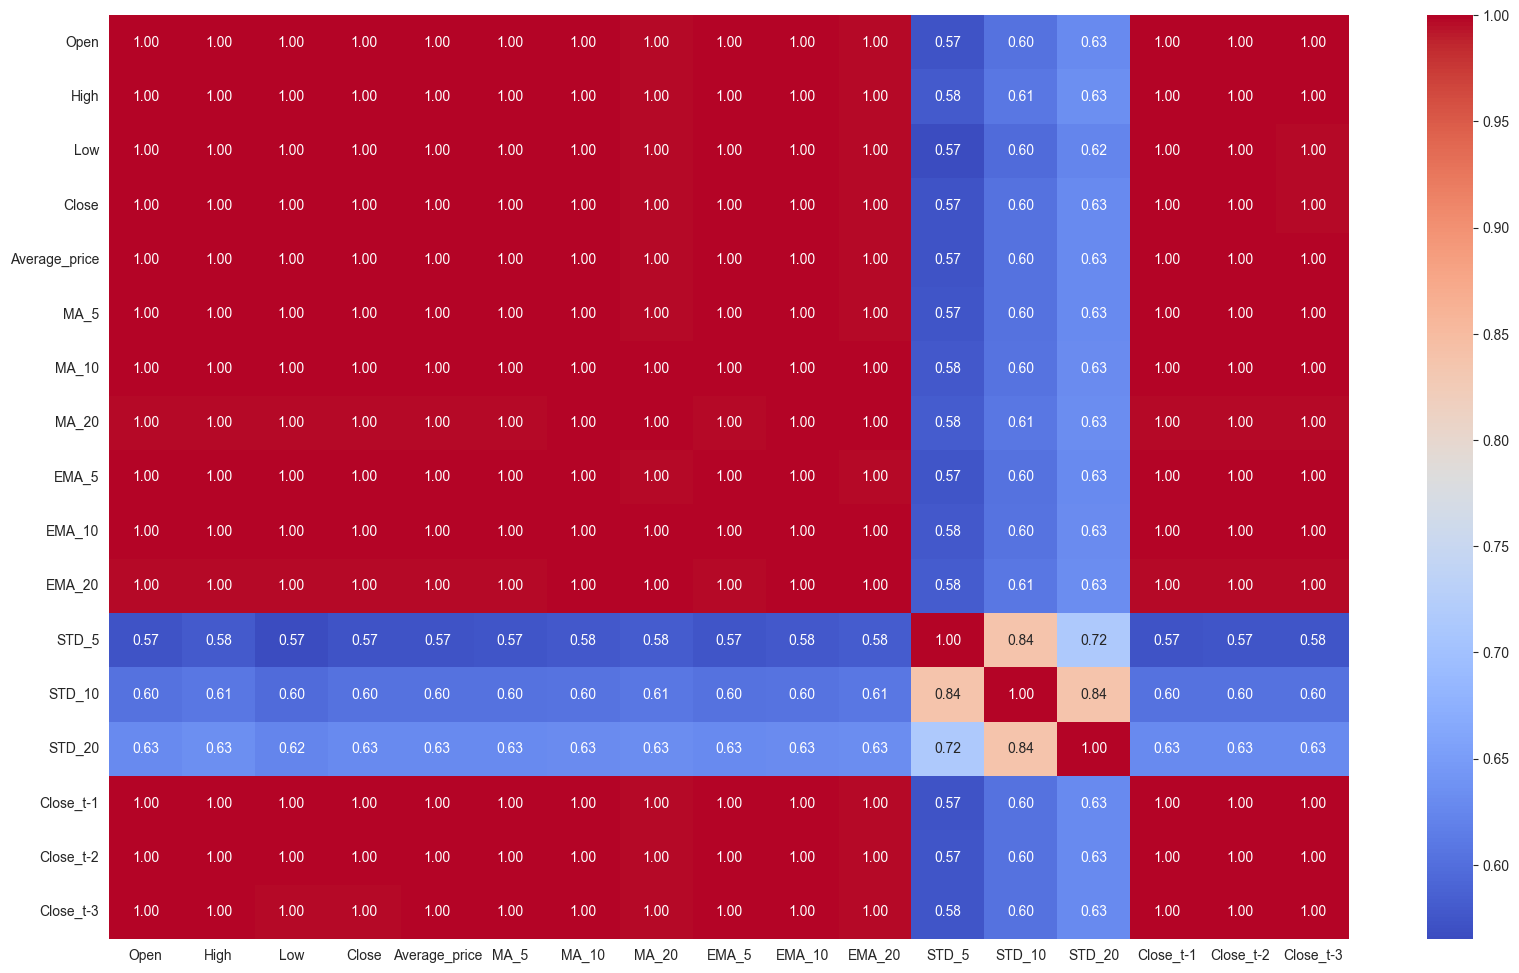

In [33]:
corr = df.corr()

plt.figure(figsize=(20,12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

Splitting test and train sets

In [34]:
prediction_days = 10
df['Target'] = df['Close'].shift(-prediction_days)
df.dropna(inplace=True)

X = df.drop(columns=['Target'])
y = df['Target']

print(y.tail())

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=False)

Date
2017-10-23    20.13
2017-10-24    20.21
2017-10-25    20.12
2017-10-26    19.99
2017-10-27    20.49
Name: Target, dtype: float64


# Models

Decision tree (with only max_depth adjusted)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


C:\Users\Admin\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:66: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


[CV 1/5] END ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=3;, score=-5.761 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=3;, score=-3.340 total time=   0.1s
[CV 2/5] END ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=5;, score=-3.340 total time=   0.1s
[CV 4/5] END ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2;, score=-1.363 total time=   0.1s
[CV 1/5] END ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2;, score=-5.761 total time=   0.1s
[CV 5/5] END ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2;, score=-3.040 total time=   0.1s
[CV 2/5] END ccp_alpha=0.01, criterion=f

C:\Users\Admin\miniconda3\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


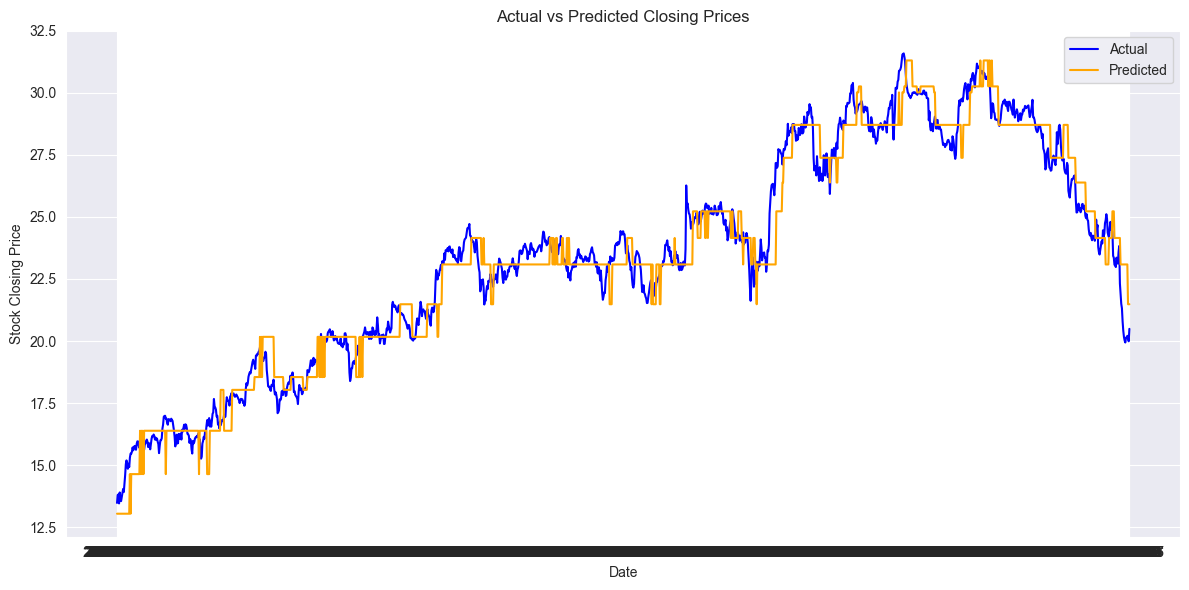

In [35]:
param_grid_DT = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features':  [None, 'log2', 'sqrt'],
    'criterion': ['friedman_mse','squared_error'],
    'ccp_alpha': [0.01, 0.015, 0.2]}

tree = GridSearchCV(estimator=DecisionTreeRegressor(),
                           param_grid=param_grid_DT,
                           cv=5,
                           scoring='neg_mean_squared_error', verbose=3,n_jobs=-1)

with parallel_backend('threading'):
    tree.fit(X_train, y_train)

print("Best Hyperparameters:", tree.best_params_)
#
print("Best Accuracy:", tree.best_score_)

y_pred = tree.predict(X_test)
evaluate(y_test, y_pred)
plot_prediction(y_pred, X_test)

## Random Forest

Fitting 3 folds for each of 1458 candidates, totalling 4374 fits


C:\Users\Admin\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:66: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


[CV 2/3] END bootstrap=True, ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=-18.998 total time=   2.4s
[CV 2/3] END bootstrap=True, ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-19.152 total time=   2.5s
[CV 1/3] END bootstrap=True, ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=-15.640 total time=   2.7s
[CV 3/3] END bootstrap=True, ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=-1.863 total time=   2.7s
[CV 1/3] END bootstrap=True, ccp_alpha=0.01, criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-16.286 total time=   2.9s[CV 3/3] END bootstrap=True

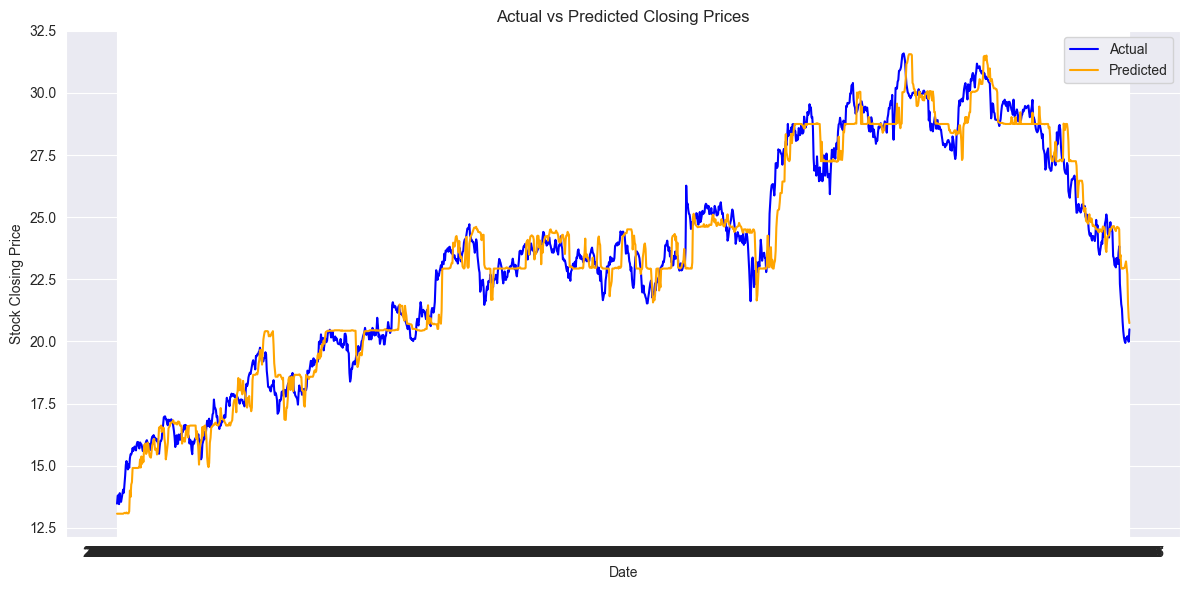

In [36]:
param_grid_RF ={
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features':  ['log2', 'sqrt', None],
    'criterion': ['friedman_mse', 'squared_error'],
    'ccp_alpha': [0.01, 0.015, 0.02],
    'n_estimators': [100, 250, 500],
    'bootstrap': [True]
}

forest = GridSearchCV(estimator=RandomForestRegressor(),
                           param_grid=param_grid_RF,
                           cv=3,
                           scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)

with parallel_backend('threading'):
    forest.fit(X_train, y_train)

print("Best Hyperparameters:", forest.best_params_)
print("Best Accuracy:", forest.best_score_)

y_pred = forest.predict(X_test)
evaluate(y_test, y_pred)
plot_prediction(y_pred, X_test)

Gradient Boosting

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


C:\Users\Admin\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:66: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


[CV 2/3] END ccp_alpha=0.01, criterion=friedman_mse, learning_rate=0.2, max_depth=10, min_samples_leaf=40, n_estimators=100;, score=-20.817 total time=   6.6s
[CV 2/3] END ccp_alpha=0.01, criterion=friedman_mse, learning_rate=0.2, max_depth=10, min_samples_leaf=25, n_estimators=100;, score=-21.473 total time=   7.2s
[CV 3/3] END ccp_alpha=0.01, criterion=friedman_mse, learning_rate=0.2, max_depth=10, min_samples_leaf=40, n_estimators=100;, score=-1.684 total time=   7.2s
[CV 1/3] END ccp_alpha=0.01, criterion=friedman_mse, learning_rate=0.2, max_depth=10, min_samples_leaf=25, n_estimators=100;, score=-23.085 total time=   7.4s
[CV 3/3] END ccp_alpha=0.01, criterion=friedman_mse, learning_rate=0.2, max_depth=10, min_samples_leaf=25, n_estimators=100;, score=-1.807 total time=   7.5s
[CV 1/3] END ccp_alpha=0.01, criterion=friedman_mse, learning_rate=0.2, max_depth=10, min_samples_leaf=40, n_estimators=100;, score=-21.757 total time=   7.7s
[CV 3/3] END ccp_alpha=0.01, criterion=friedman_

C:\Users\Admin\miniconda3\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'ccp_alpha': 0.01, 'criterion': 'friedman_mse', 'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 40, 'n_estimators': 300}
Best Accuracy: -14.37494664105362
Test RMSE: 0.88
Test R2: 0.96
Test MAPE: 0.03
            Actual  Predicted
Date                         
2017-10-23   20.13  22.829079
2017-10-24   20.21  22.258595
2017-10-25   20.12  21.812918
2017-10-26   19.99  21.476082
2017-10-27   20.49  21.476082


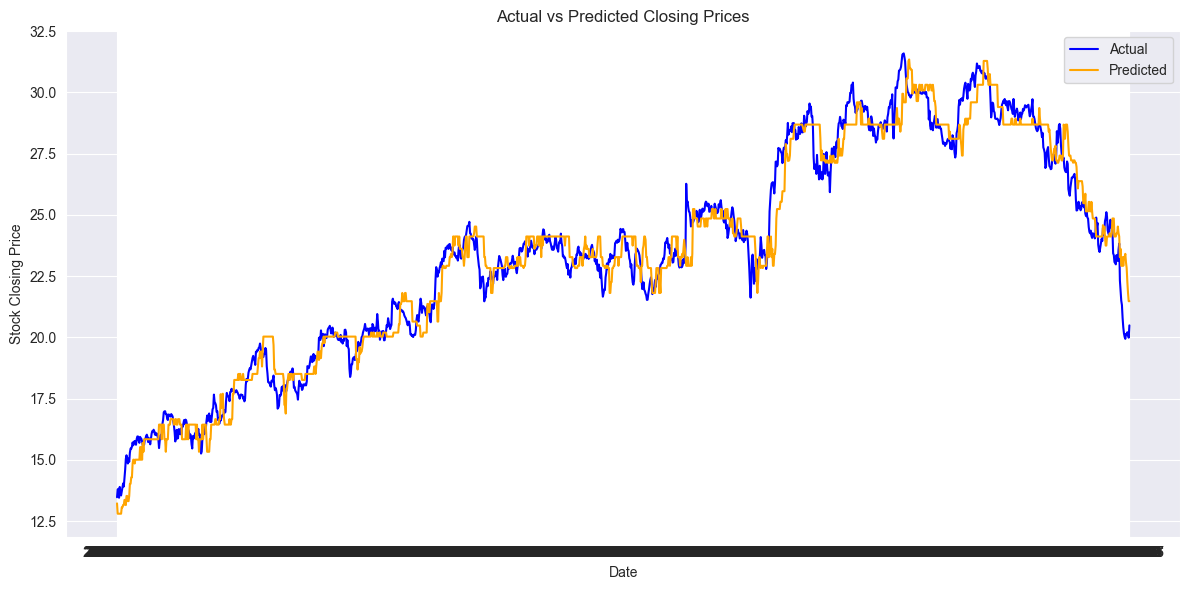

In [37]:
param_grid_GBR ={
    'max_depth': [10, 15, 20],
    'n_estimators': [100, 200, 300],
    'min_samples_leaf': [25, 40, 60],
    'learning_rate': [0.2, 0.3, 0.4],
    'ccp_alpha': [0.01, 0.015, 0.2],
    'criterion': ['friedman_mse', 'squared_error']
}
grad = GridSearchCV(estimator=GradientBoostingRegressor(),
                           param_grid=param_grid_GBR,
                           cv=3,
                           scoring='neg_mean_squared_error',verbose=3,n_jobs=-1)

with parallel_backend('threading'):
    grad.fit(X_train, y_train)

print("Best Hyperparameters:", grad.best_params_)
print("Best Accuracy:", grad.best_score_)

y_pred = grad.predict(X_test)
evaluate(y_test, y_pred)
plot_prediction(y_pred, X_test)

XGBoost

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


C:\Users\Admin\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:66: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


[CV 5/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=600, subsample=1.1;, score=nan total time=   0.0s
[CV 3/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=600, subsample=1.1;, score=nan total time=   0.0s
[CV 2/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=600, subsample=1.2;, score=nan total time=   0.0s
[CV 1/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=600, subsample=1.2;, score=nan total time=   0.0s
[CV 2/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=600, subsample=1.1;, score=nan total time=   0.0s
[CV 1/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=600, subsample=1.1;, score=nan total time=   0.0s
[CV 4/5] END colsample_bytree=0.9,

C:\Users\Admin\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
7290 fits failed out of a total of 10935.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3645 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\miniconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\Admin\miniconda3\Lib\site-packages\xgboost\sklearn.py", line 1108, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Us

Best Hyperparameters: {'colsample_bytree': 0.95, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 600, 'subsample': 1.0}
Best Accuracy: -6.734479896047672
Test RMSE: 0.93
Test R2: 0.95
Test MAPE: 0.03
            Actual  Predicted
Date                         
2017-10-23   20.13  21.458426
2017-10-24   20.21  21.833412
2017-10-25   20.12  21.763885
2017-10-26   19.99  21.482420
2017-10-27   20.49  21.992851


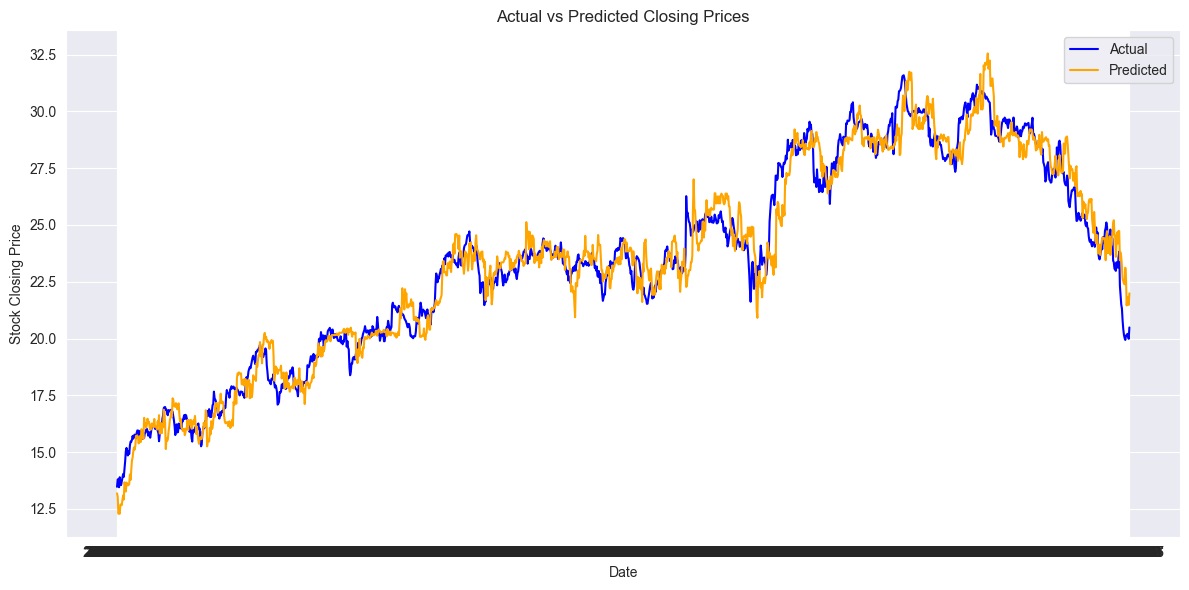

XGBoost Performance:
Training RMSE: 0.56, R2: 1.00, MAPE: 0.02
Test RMSE: 0.93, R2: 0.95, MAPE: 0.03



In [38]:
param_grid_XGB = {
    'learning_rate': [0.2, 0.25, 0.3],
    'n_estimators': [600, 800, 1000],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'gamma': [0.1, 0.15, 0.2],
    'subsample': [1.0, 1.1, 1.2],
    'colsample_bytree': [0.9, 0.92, 0.95],
}

xgb_cv = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid_XGB, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)

with parallel_backend('threading'):
    xgb_cv.fit(X_train, y_train)

print("Best Hyperparameters:", xgb_cv.best_params_)
print("Best Accuracy:", xgb_cv.best_score_)

y_pred = xgb_cv.predict(X_test)
evaluate(y_test, y_pred)
plot_prediction(y_pred, X_test)
compare_train_test(xgb_cv, X_train, X_test, y_train, y_test, "XGBoost")

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


C:\Users\Admin\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
7290 fits failed out of a total of 10935.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3645 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\miniconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\Admin\miniconda3\Lib\site-packages\xgboost\sklearn.py", line 1108, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Us

Test RMSE: 0.88
Test R2: 0.96
Test MAPE: 0.03
            Actual  Predicted
Date                         
2017-10-23   20.13  22.643527
2017-10-24   20.21  22.261878
2017-10-25   20.12  21.608365
2017-10-26   19.99  21.166680
2017-10-27   20.49  21.181716


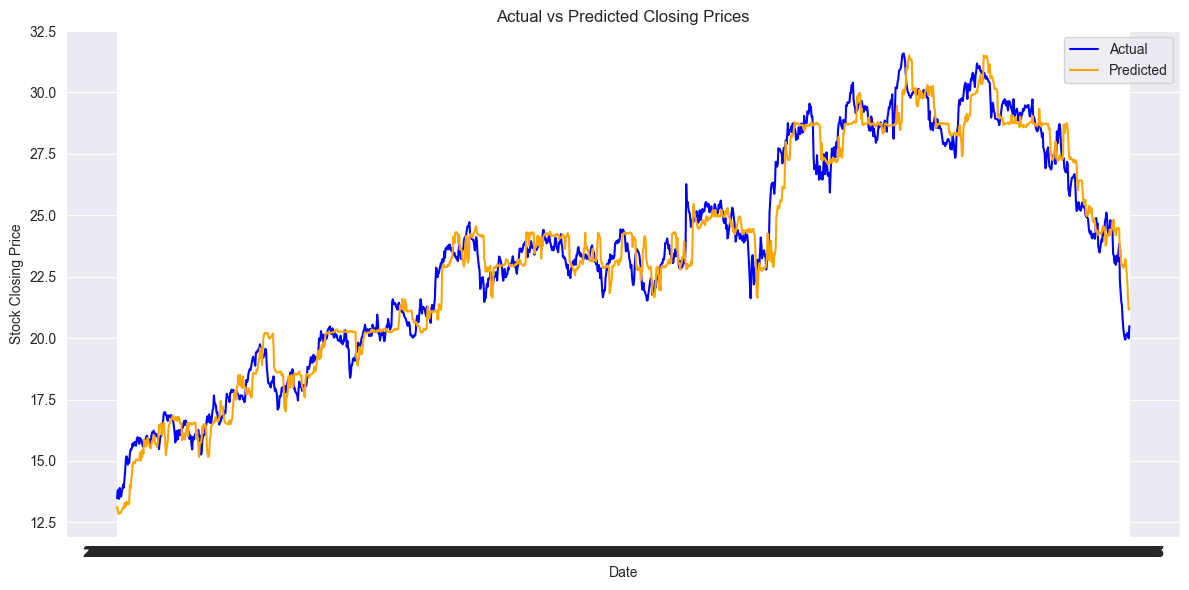

In [39]:
vr = VotingRegressor([('gbr', grad.best_estimator_),
                      ('xgb', xgb_cv),
                      ('rf', forest.best_estimator_)],
                    weights=[2,1,3])
vr.fit(X_train, y_train)
y_pred = vr.predict(X_test)
evaluate(y_test, y_pred)
plot_prediction(y_pred, X_test)

Overfitting test (comparing performance between testing and training sets)

In [40]:
compare_train_test(tree, X_train, X_test, y_train, y_test, "Decision Tree")
compare_train_test(forest, X_train, X_test, y_train, y_test, "Random Forest")
compare_train_test(grad, X_train, X_test, y_train, y_test, "Gradient Boosting")
compare_train_test(xgb_cv, X_train, X_test, y_train, y_test, "XGBoost")
compare_train_test(vr, X_train, X_test, y_train, y_test, "Voting Regressor")

Decision Tree Performance:
Training RMSE: 1.04, R2: 0.99, MAPE: 0.05
Test RMSE: 0.92, R2: 0.96, MAPE: 0.03

Random Forest Performance:
Training RMSE: 1.02, R2: 0.99, MAPE: 0.05
Test RMSE: 0.90, R2: 0.96, MAPE: 0.03

Gradient Boosting Performance:
Training RMSE: 0.97, R2: 0.99, MAPE: 0.04
Test RMSE: 0.88, R2: 0.96, MAPE: 0.03

XGBoost Performance:
Training RMSE: 0.56, R2: 1.00, MAPE: 0.02
Test RMSE: 0.93, R2: 0.95, MAPE: 0.03

Voting Regressor Performance:
Training RMSE: 0.90, R2: 0.99, MAPE: 0.04
Test RMSE: 0.88, R2: 0.96, MAPE: 0.03

